# Thai to English Machine translation

In [1]:
# Import some necessary libraries
import torch
from torch import nn
import torch.nn.functional as F

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparation

In [2]:
# I obtained the data from VISTEC ai research.
# linked: https://airesearch.in.th/releases/machine-translation-datasets/

# Read from csv
import pandas as pd
src = '/root/projects/NLP/Assignment/23_Feb_Machine_translation/scb-mt-en-th-2020/generated_reviews_crowd.csv'
df = pd.read_csv(src)

SRC_LANGUAGE = 'th'
TRG_LANGUAGE = 'en'

In [3]:
df.head()

,en_text,th_text
0,Doesn't snap together well.,เข้ากันไม่ค่อยดี
1,Charged it after every use as directed for abo...,เรียกเก็บเงินหลังจากใช้งานทุกครั้งตามที่กำกับไ...
2,"My son wanted this movie so badly, that he sai...",ลูกชายของฉันต้องการภาพยนตร์เรื่องนี้เพื่อไม่ดี...
3,But his writing has degenerated in later books.,แต่หนังสือเล่มที่ผ่านมาของเขามันดูด้อยคุณภาพลง
4,"It was supposed to be a good bag, well you get...",มันควรที่จะเป็นกระเป๋าที่ดี เอ้อ เธอได้ในสิ่งท...


In [5]:
# Declare tokenizer for English and Thai
from tqdm import tqdm
from attacut import tokenize, Tokenizer
from torchtext.data.utils import get_tokenizer
tokenizer_target = get_tokenizer('spacy', language='en_core_web_sm')
atta = Tokenizer(model="attacut-sc")

# Store the pair or English and Thai sentences.
word_pair_tokenzier = []
with tqdm(range(df.shape[0])) as pbar:
    for i,text in df.iterrows():
        source = atta.tokenize(text[1]) #en
        target = tokenizer_target(text[0]) #th
        word_pair_tokenzier.append((source, target))
        pbar.update(1)

word_pair_tokenzier

100%|██████████| 24587/24587 [01:52<00:00, 218.34it/s]


[(['เข้า', 'กัน', 'ไม่', 'ค่อย', 'ดี'],
  ['Does', "n't", 'snap', 'together', 'well', '.']),
 (['เรียก',
   'เก็บ',
   'เงิน',
   'หลัง',
   'จาก',
   'ใช้',
   'งาน',
   'ทุก',
   'ครั้ง',
   'ตาม',
   'ที่',
   'กำกับ',
   'ไว้',
   'เป็น',
   'เวลา',
   'ประมาณ',
   ' ',
   '4',
   ' ',
   'เดือน',
   'เริ่ม',
   'มี',
   'ปัญหา',
   'ใน',
   'การ',
   'เก็บ',
   'ประจุ'],
  ['Charged',
   'it',
   'after',
   'every',
   'use',
   'as',
   'directed',
   'for',
   'about',
   '4',
   'months',
   ',',
   'started',
   'having',
   'difficulty',
   'holding',
   'a',
   'charge',
   'on',
   'it',
   '.']),
 (['ลูก',
   'ชาย',
   'ของ',
   'ฉัน',
   'ต้องการ',
   'ภาพยนตร์',
   'เรื่อง',
   'นี้',
   'เพื่อ',
   'ไม่',
   'ดี',
   ',',
   ' ',
   'ที่',
   'เขา',
   'กล่าว',
   'ว่า',
   'มัน',
   'อย่าง',
   'น้อย',
   '20',
   'ครั้ง',
   '.'],
  ['My',
   'son',
   'wanted',
   'this',
   'movie',
   'so',
   'badly',
   ',',
   'that',
   'he',
   'said',
   'it',
   'at',
   'l

In [6]:
# This part is just for loading and saving

# import pickle
# file = open('/root/projects/NLP/Assignment/23_Feb_Machine_translation/object/word_pair_tokenize.pkl', 'wb')
# pickle.dump(word_pair_tokenzier, file)

# file = open('/root/projects/NLP/Assignment/23_Feb_Machine_translation/object/word_pair_tokenize.pkl', 'rb')
# word_pair_tokenzier = pickle.load(file)


In [7]:
# Spliting between train, validation and test sets

import random

dataset = df.values.tolist()
random.shuffle(dataset)
train_data_set_size = int(len(dataset) * 0.8)

train_dataset = dataset[:train_data_set_size]
test = dataset[train_data_set_size:]

train_size = int(train_data_set_size * 0.8)
train = train_dataset[:train_size]
val = train_dataset[train_size:]

In [8]:
# Manually create vocabulary.
# Used defaultdict as it can return the values for the unknown key.
from collections import defaultdict

def def_w2i_val():
    return 0
def def_i2w_val():
    return '<unk>'

word2index_th = defaultdict(def_w2i_val)
word2index_en = defaultdict(def_w2i_val)
index2word_th = defaultdict(def_i2w_val)
index2word_en = defaultdict(def_i2w_val)


In [9]:
# Manually created dict of vocab for th and en using simple for loop.
# ['<unk>', '<pad>', '<sos>', '<eos>']
th_counter = 4
en_counter = 4
for idx, text in enumerate(word_pair_tokenzier):

    th_token = text[0]
    en_token = text[1]


    if idx == 0:
        index2word_th[idx] = '<unk>'
        index2word_en[idx] = '<unk>'

        word2index_th['unk'] = 0
        word2index_en['unk'] = 0

    elif idx == 1:
        index2word_th[idx] = '<pad>'
        index2word_en[idx] = '<pad>'
        word2index_th['<pad>'] = 1
        word2index_en['<pad>'] = 1

    elif idx == 2:
        index2word_th[idx] = '<sos>'
        index2word_en[idx] = '<sos>'
        word2index_th['<sos>'] = 2
        word2index_en['<sos>'] = 2

    elif idx == 3:
        index2word_th[idx] = '<eos>'
        index2word_en[idx] = '<eos>'
        word2index_th['<eos>'] = 3
        word2index_en['<eos>'] = 3

    else:
        for th_word in th_token:
            if th_word not in index2word_th.values():
                index2word_th[th_counter] = th_word
                word2index_th[th_word] = th_counter
                th_counter += 1

        for en_word in en_token:
            en_word = en_word.lower()
            if en_word not in index2word_en.values():
                index2word_en[en_counter] = en_word
                word2index_en[en_word] = en_counter
                en_counter += 1

In [10]:
print(f'word to index Thai: {len(word2index_th)}, index to word Thai: {len(index2word_th)}')
print(f'word to index Eng: {len(word2index_en)}, index to word Eng: {len(index2word_en)}')

word to index Thai: 11157, index to word Thai: 11157
word to index Eng: 11938, index to word Eng: 11938


In [11]:
# # Create word2index
# word2index_th = dict([(value, key) for key, value in index2word_th.items()])
# word2index_en = dict([(value, key) for key, value in index2word_en.items()])

In [12]:
# Functions for collate batch
def convert_text_to_index_th(sentence):
    #sentence = attacut.tokenize(sentence)

    sentence = atta.tokenize(sentence)

    index_torch = torch.tensor([word2index_th[index] for index in sentence])
    

    return torch.cat((torch.tensor([2]), 
                      torch.tensor(index_torch), 
                      torch.tensor([3])))

def convert_text_to_index_en(sentence):
    sentence = tokenizer_target(sentence)
    index_torch = torch.tensor([word2index_en[index] for index in sentence])
    
    return torch.cat((torch.tensor([2]), 
                      torch.tensor(index_torch), 
                      torch.tensor([3])))

In [13]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence #making each batch same length

pad_ix = word2index_en['<pad>']

#this function gonna be called by DataLoader
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []

    for trg_sample, src_sample in batch:

        src_transform = convert_text_to_index_th(src_sample)
        trg_transform = convert_text_to_index_en(trg_sample)

        src_batch.append(src_transform)
        trg_batch.append(trg_transform)
        src_len_batch.append(src_transform.size(0))
            
    src_batch = pad_sequence(src_batch, padding_value=1)
    trg_batch = pad_sequence(trg_batch, padding_value=1)
        
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [14]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val, batch_size=batch_size,
                               shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)

In [15]:
for th, _, en in train_loader:
    print(f'Th shape {th.shape}')
    print(f'En shape {en.shape}')
    break

Th shape torch.Size([51, 32])
En shape torch.Size([42, 32])


/tmp/ipykernel_19961/351837704.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(index_torch),
/tmp/ipykernel_19961/351837704.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(index_torch),


In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn       = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc        = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout   = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src: [src len, batch size]
        #src len: [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                            src_len.to('cpu'), enforce_sorted=False)
        
        #packed_outputs contain all hidden states including padding guy
        #hidden contains the last hidden states of the non-padded guys
        packed_outputs, hidden = self.rnn(packed_embedded)
        #hidden: [n layers * num directions, batch size, hid dim]
        
        #convert packed_outputs to the guy that does not contain hidden states for padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        #outputs: [src len, batch size, hid dim * num directions]
        
        #take the last hidden states from backward and forward
        #hidden: (f, b, f, b)
        forward  = hidden[-2, :, :]  #[batch size, hid dim]
        backward = hidden[-1, :, :]  #[batch size, hid dim]
        
        hidden = torch.tanh(self.fc(torch.cat((forward, backward), dim = 1))) 
        #hidden: [batch size, hid dim]
        
        return outputs, hidden

In [17]:
class Attention(nn.Module):
    def __init__(self, hid_dim, variants):
        super().__init__()
        self.variants = variants
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim,     hid_dim) #for decoder
        self.U = nn.Linear(hid_dim * 2, hid_dim) #for encoder outputs
                
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]

        if self.variants == 'additive': #work
            #repeat decoder hidden state src_len times
            hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
            #hidden = [batch size, src len, hid dim]
            
            energy = torch.tanh(self.W(hidden) + self.U(encoder_outputs))
            #energy = [batch size, src len, hid dim]
            
            attention = self.v(energy).squeeze(2)
            #attention = [batch size, src len]

            #use masked_fill_ if you want in-place
            attention = attention.masked_fill(mask, -1e10)
            
        elif self.variants == 'general': #work
            hidden = hidden.unsqueeze(1).repeat(1, 1, 2)
            #hidden = [batch size, 1, hid dim*2]
            #encoder_outputs = [batch size, hid dim * 2, src len]

            energy = torch.bmm(hidden, encoder_outputs.transpose(1, 2))
            attention = energy.squeeze(1)
            #attention = [batch size, src len]

        elif self.variants == 'multiplicative':
            wh = self.W(hidden).unsqueeze(1).repeat(1, 1, 2)
            #wh = [batch size, 1, hid dim*2]
            #encoder_outputs = [batch size, hid dim * 2, src len]

            energy = torch.bmm(wh, encoder_outputs.transpose(1, 2))
            attention = energy.squeeze(1)

        #attention = [batch size, src len]
        return F.softmax(attention, dim = 1)

In [18]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        
        #input = [batch size]
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
        #a = [batch size, src len]

        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs) #Ct
        #weighted = [batch size, 1, hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        #weighted = [1, batch size, hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input = [1, batch size, (hid dim * 2) + emb dim]
        
        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [1, batch size, hid dim]
        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output   = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1))
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [19]:
class Seq2SeqPackedAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        #src: [src len, batch size]
        
        mask = (src == self.src_pad_idx).permute(1, 0)
        #mask: [batch size, src len]
        #we need to permute to make the mask same shape as attention...
        return mask

        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src: [src len, batch size]
        #src len: [batch size]
        #trg: [trg len, batch size]
        
        batch_size = src.shape[1]
        trg_len    = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim #define in decoder
        
        #because decoder decodes each step....let's create a list that gonna append the result to this guy
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #because decoder decodes each step....let's memorize the attention done in each step....
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        #let's start!!!
        #1. encoder
        encoder_outputs, hidden = self.encoder(src, src_len)
        #encoder_outputs: [src len, batch size, hid dim * num directions]
        #hidden: [batch size, hid dim]
        
        #set the first input to the decoder
        input_ = trg[0,:]  #basically <sos>
        
        #create the mask for use in this step
        mask = self.create_mask(src)
        
        #2. for each of trg word
        for t in range(1, trg_len):

            #3. decode (hidden is always carry forward)
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            #output:   [batch size, output_dim]
            #hidden:   [batch size, hid_dim]
            #attention::[batch size, src len]  ==> how each of src token is important to input_ 
            
            #4. append the results to outputs and attentions
            outputs[t] = output
            attentions[t] = attention
            
            #5. get the result, using argmax
            top1 = output.argmax(1)  #find the maximum index of dimension 1, which is output_dim
            
            #6. based on the teacher forcing ratio, 
            teacher_force_or_not = random.random() < teacher_forcing_ratio
                    #if teacher forcing, next input is the next trg
                    #if no teacher forcing, the next input is the argmax guy...
            input_ = trg[t] if teacher_force_or_not else top1  #autoregressive
            
        return outputs, attentions #outputs for predicting the word, attentions to see which word is important
        
        

In [20]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

## Training

### 6.1 General Attention

In [21]:
input_dim   = len(index2word_th)
output_dim  = len(index2word_en)
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = 1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

attn = Attention(hid_dim, variants='general')
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model_general = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model_general.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(11157, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(11938, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=11938, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [22]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model_general)

2856192
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
3056128
1966080
786432
  1536
  1536
21392896
 11938
______
33750946


Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token. 

In [23]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model_general.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = 1) #combine softmax with cross entropy

The training is very similar to part 1.

In [24]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [25]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

#### Putting everything together

In [26]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

/tmp/ipykernel_19961/351837704.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(index_torch),
/tmp/ipykernel_19961/351837704.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(index_torch),


In [27]:
print(train_loader_length)

for th, _, en in train_loader:
    print(f'Th shape {th.shape}')
    print(f'En shape {en.shape}')
    break

492


/tmp/ipykernel_19961/351837704.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(index_torch),
/tmp/ipykernel_19961/351837704.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(index_torch),


Th shape torch.Size([48, 32])
En shape torch.Size([47, 32])


In [28]:
print(th)

tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [254,   4,   4,  ...,  66, 431,  66],
        [255,  90, 111,  ..., 505, 235,  78],
        ...,
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]])


In [29]:
print(en)

tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   0,    0,    0,  ...,    0,    0,    0],
        [ 264, 1439,  330,  ...,  893,  307,  410],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])


In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [33]:
import time
import math
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'models/{model_general.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model_general, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model_general, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_general.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

/tmp/ipykernel_19961/351837704.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(index_torch),
/tmp/ipykernel_19961/351837704.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(index_torch),


Epoch: 01 | Time: 5m 58s
	Train Loss: 4.800 | Train PPL: 121.551
	 Val. Loss: 5.129 |  Val. PPL: 168.915
Epoch: 02 | Time: 5m 54s
	Train Loss: 4.206 | Train PPL:  67.117
	 Val. Loss: 4.880 |  Val. PPL: 131.592
Epoch: 03 | Time: 6m 7s
	Train Loss: 3.743 | Train PPL:  42.205
	 Val. Loss: 4.774 |  Val. PPL: 118.442
Epoch: 04 | Time: 5m 58s
	Train Loss: 3.381 | Train PPL:  29.414
	 Val. Loss: 4.777 |  Val. PPL: 118.792
Epoch: 05 | Time: 5m 56s
	Train Loss: 3.068 | Train PPL:  21.493
	 Val. Loss: 4.793 |  Val. PPL: 120.706
Epoch: 06 | Time: 5m 54s
	Train Loss: 2.840 | Train PPL:  17.121
	 Val. Loss: 4.810 |  Val. PPL: 122.772
Epoch: 07 | Time: 5m 55s
	Train Loss: 2.668 | Train PPL:  14.416
	 Val. Loss: 4.835 |  Val. PPL: 125.817
Epoch: 08 | Time: 5m 53s
	Train Loss: 2.520 | Train PPL:  12.426
	 Val. Loss: 4.852 |  Val. PPL: 127.963
Epoch: 09 | Time: 5m 53s
	Train Loss: 2.393 | Train PPL:  10.946
	 Val. Loss: 4.932 |  Val. PPL: 138.658
Epoch: 10 | Time: 5m 57s
	Train Loss: 2.276 | Train PPL:

Text(0, 0.5, 'loss')

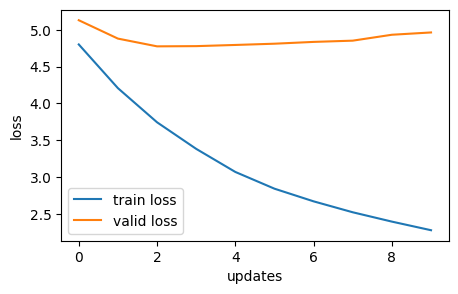

In [34]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [35]:
model_general.load_state_dict(torch.load(save_path))
test_loss = evaluate(model_general, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

/tmp/ipykernel_19961/351837704.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(index_torch),
/tmp/ipykernel_19961/351837704.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(index_torch),


| Test Loss: 4.754 | Test PPL: 116.051 |


### 6.2 Multiplicative attention

In [36]:
input_dim   = len(index2word_th)
output_dim  = len(index2word_en)
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = 1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

attn = Attention(hid_dim, variants='multiplicative')
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model_multiplicative = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model_multiplicative.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(11157, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(11938, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=11938, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [37]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model_multiplicative)

2856192
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
3056128
1966080
786432
  1536
  1536
21392896
 11938
______
33750946


Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token. 

In [39]:
import torch.optim as optim

PAD_IDX = 1

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model_multiplicative.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

In [40]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'models/{model_multiplicative.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model_general, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model_general, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_general.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

/tmp/ipykernel_19961/351837704.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(index_torch),
/tmp/ipykernel_19961/351837704.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(index_torch),


Epoch: 01 | Time: 5m 10s
	Train Loss: 3.334 | Train PPL:  28.041
	 Val. Loss: 4.780 |  Val. PPL: 119.074
Epoch: 02 | Time: 5m 15s
	Train Loss: 3.323 | Train PPL:  27.738
	 Val. Loss: 4.777 |  Val. PPL: 118.689
Epoch: 03 | Time: 5m 14s
	Train Loss: 3.326 | Train PPL:  27.840
	 Val. Loss: 4.776 |  Val. PPL: 118.659
Epoch: 04 | Time: 5m 10s
	Train Loss: 3.322 | Train PPL:  27.705
	 Val. Loss: 4.778 |  Val. PPL: 118.916
Epoch: 05 | Time: 5m 8s
	Train Loss: 3.329 | Train PPL:  27.901
	 Val. Loss: 4.778 |  Val. PPL: 118.811
Epoch: 06 | Time: 5m 7s
	Train Loss: 3.319 | Train PPL:  27.619
	 Val. Loss: 4.774 |  Val. PPL: 118.445
Epoch: 07 | Time: 5m 4s
	Train Loss: 3.327 | Train PPL:  27.863
	 Val. Loss: 4.777 |  Val. PPL: 118.769
Epoch: 08 | Time: 5m 3s
	Train Loss: 3.326 | Train PPL:  27.818
	 Val. Loss: 4.772 |  Val. PPL: 118.203
Epoch: 09 | Time: 5m 4s
	Train Loss: 3.335 | Train PPL:  28.074
	 Val. Loss: 4.774 |  Val. PPL: 118.344
Epoch: 10 | Time: 5m 2s
	Train Loss: 3.322 | Train PPL:  27.

Text(0, 0.5, 'loss')

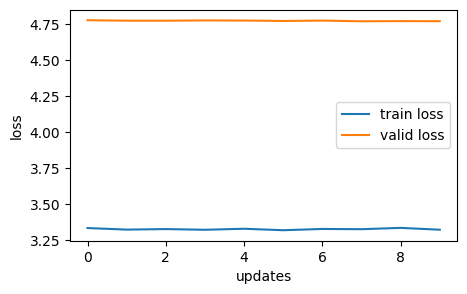

In [41]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [42]:
model_multiplicative.load_state_dict(torch.load(save_path))
test_loss = evaluate(model_multiplicative, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

/tmp/ipykernel_19961/351837704.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(index_torch),
/tmp/ipykernel_19961/351837704.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(index_torch),


| Test Loss: 5.640 | Test PPL: 281.568 |


### 6.3 Additive attention

In [43]:
input_dim   = len(index2word_th)
output_dim  = len(index2word_en)
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = 1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

attn = Attention(hid_dim, variants='additive')
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model_additive = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model_additive.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(11157, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(11938, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=11938, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [44]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model_additive)

2856192
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
3056128
1966080
786432
  1536
  1536
21392896
 11938
______
33750946


Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token. 

In [45]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model_additive.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

In [46]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'models/{model_additive.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model_general, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model_general, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_general.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

/tmp/ipykernel_19961/351837704.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(index_torch),
/tmp/ipykernel_19961/351837704.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(index_torch),


Epoch: 01 | Time: 4m 50s
	Train Loss: 3.323 | Train PPL:  27.736
	 Val. Loss: 4.773 |  Val. PPL: 118.306
Epoch: 02 | Time: 4m 59s
	Train Loss: 3.326 | Train PPL:  27.829
	 Val. Loss: 4.779 |  Val. PPL: 118.953
Epoch: 03 | Time: 4m 57s
	Train Loss: 3.330 | Train PPL:  27.944
	 Val. Loss: 4.776 |  Val. PPL: 118.607
Epoch: 04 | Time: 4m 57s
	Train Loss: 3.337 | Train PPL:  28.139
	 Val. Loss: 4.774 |  Val. PPL: 118.351
Epoch: 05 | Time: 4m 57s
	Train Loss: 3.326 | Train PPL:  27.829
	 Val. Loss: 4.776 |  Val. PPL: 118.688
Epoch: 06 | Time: 4m 59s
	Train Loss: 3.329 | Train PPL:  27.916
	 Val. Loss: 4.774 |  Val. PPL: 118.420
Epoch: 07 | Time: 5m 1s
	Train Loss: 3.322 | Train PPL:  27.714
	 Val. Loss: 4.779 |  Val. PPL: 118.972
Epoch: 08 | Time: 4m 58s
	Train Loss: 3.323 | Train PPL:  27.739
	 Val. Loss: 4.772 |  Val. PPL: 118.184
Epoch: 09 | Time: 4m 54s
	Train Loss: 3.331 | Train PPL:  27.959
	 Val. Loss: 4.777 |  Val. PPL: 118.773
Epoch: 10 | Time: 4m 52s
	Train Loss: 3.331 | Train PPL:

Text(0, 0.5, 'loss')

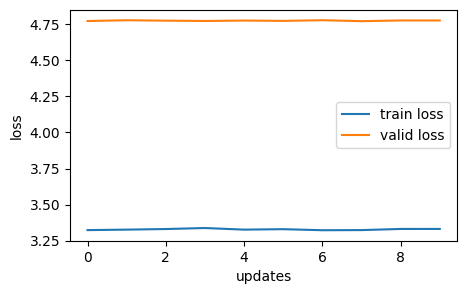

In [47]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [48]:
model_additive.load_state_dict(torch.load(save_path))
test_loss = evaluate(model_additive, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

/tmp/ipykernel_19961/351837704.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(index_torch),
/tmp/ipykernel_19961/351837704.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(index_torch),


| Test Loss: 5.386 | Test PPL: 218.237 |


## Conclusion
Based on the results, looked likes general attention is the best, so I will use the general attention to trained on the full dataset.